In [22]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(RColorBrewer)

In [61]:
df <- read.csv("./data/Bundesliga.csv")
df2 <- read.csv("./data/Bundesliga2.csv")

##  Part 3

### 1. Team Trajectories and Volatility

- Seasonal Position Trajectories
- Line plots showing seasonal ranks for top 6 teams.
- Annotate title-winning seasons.

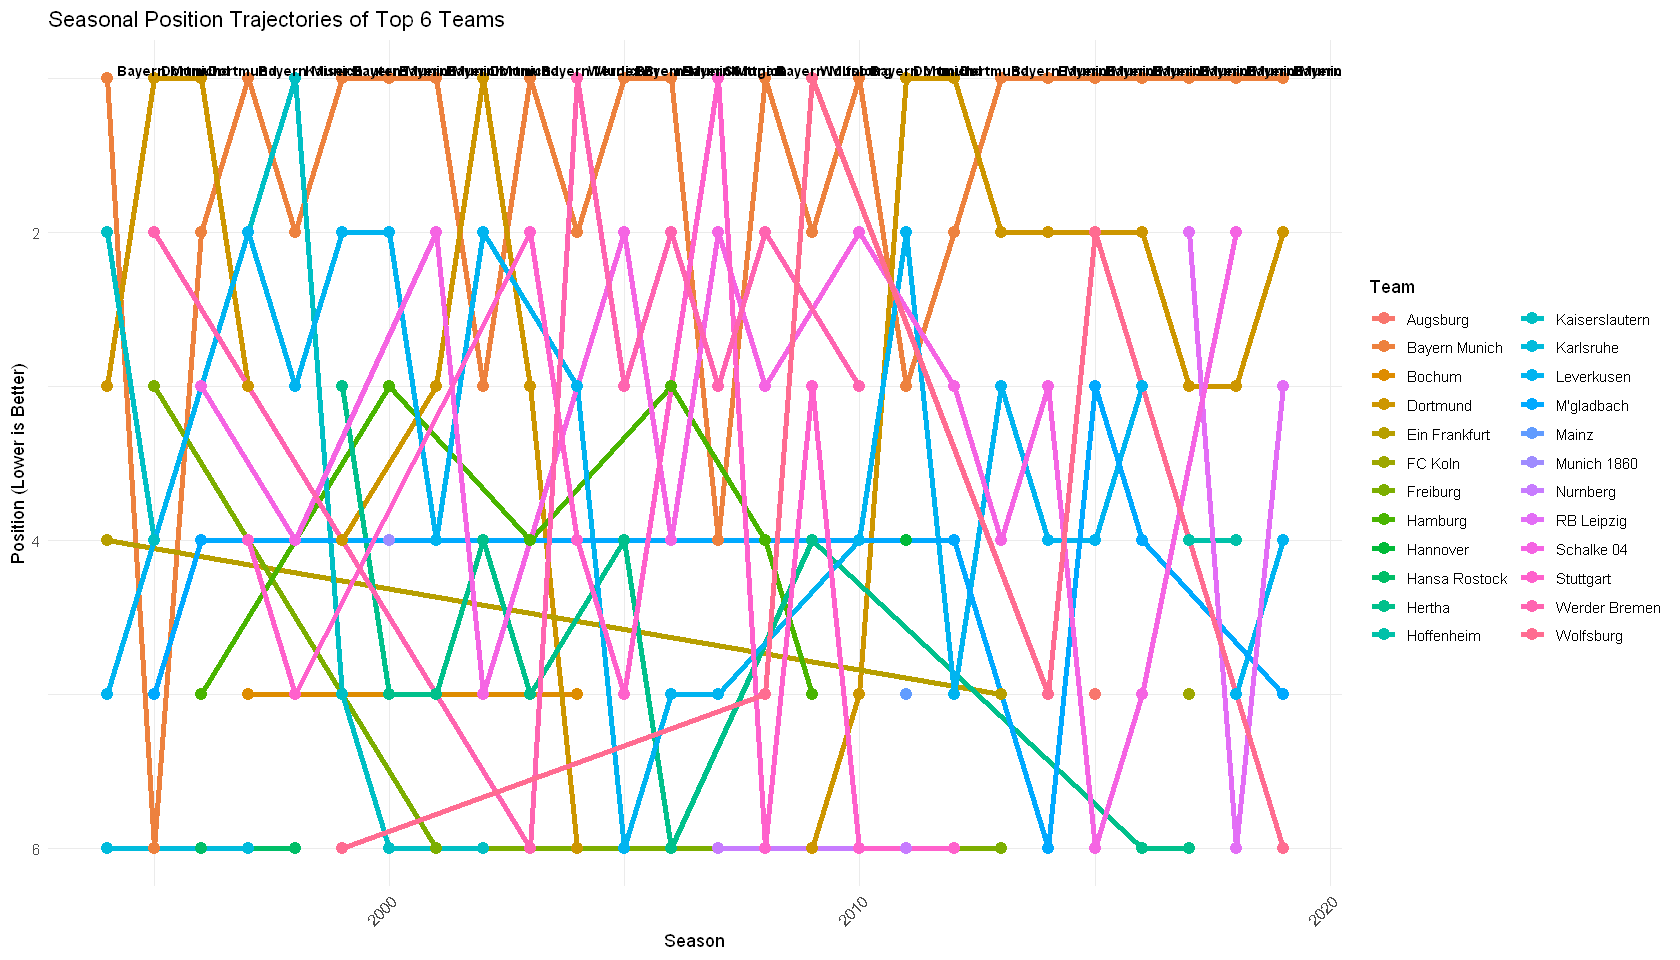

In [ ]:
df2 <- df2 %>%
  group_by(SEASON) %>%
  mutate(Rank = rank(POSITION, ties.method = "first")) %>%
  ungroup()

top_teams <- df2 %>%
  arrange(SEASON, POSITION) %>%
  group_by(SEASON) %>%
  slice_head(n = 6) %>%
  ungroup()

ggplot(top_teams, aes(x = SEASON, y = POSITION, group = TEAM, color = TEAM)) +
  geom_line(size = 1.5) +
  geom_point(size = 3) +
  scale_y_reverse() +
  labs(title = "Seasonal Position Trajectories of Top 6 Teams",
       x = "Season",
       y = "Position (Lower is Better)",
       color = "Team") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  geom_text(data = top_teams %>% filter(POSITION == 1),
            aes(label = TEAM),
            hjust = -0.1, vjust = -0.3,
            size = 3, color = "black", fontface = "bold")

2. Volatility Index

- For each team, calculate standard deviation of final rank over all seasons.
- Use a bar chart with conditional coloring (e.g., red = unstable, green = consistent).
- Add text labels above each bar with exact values.

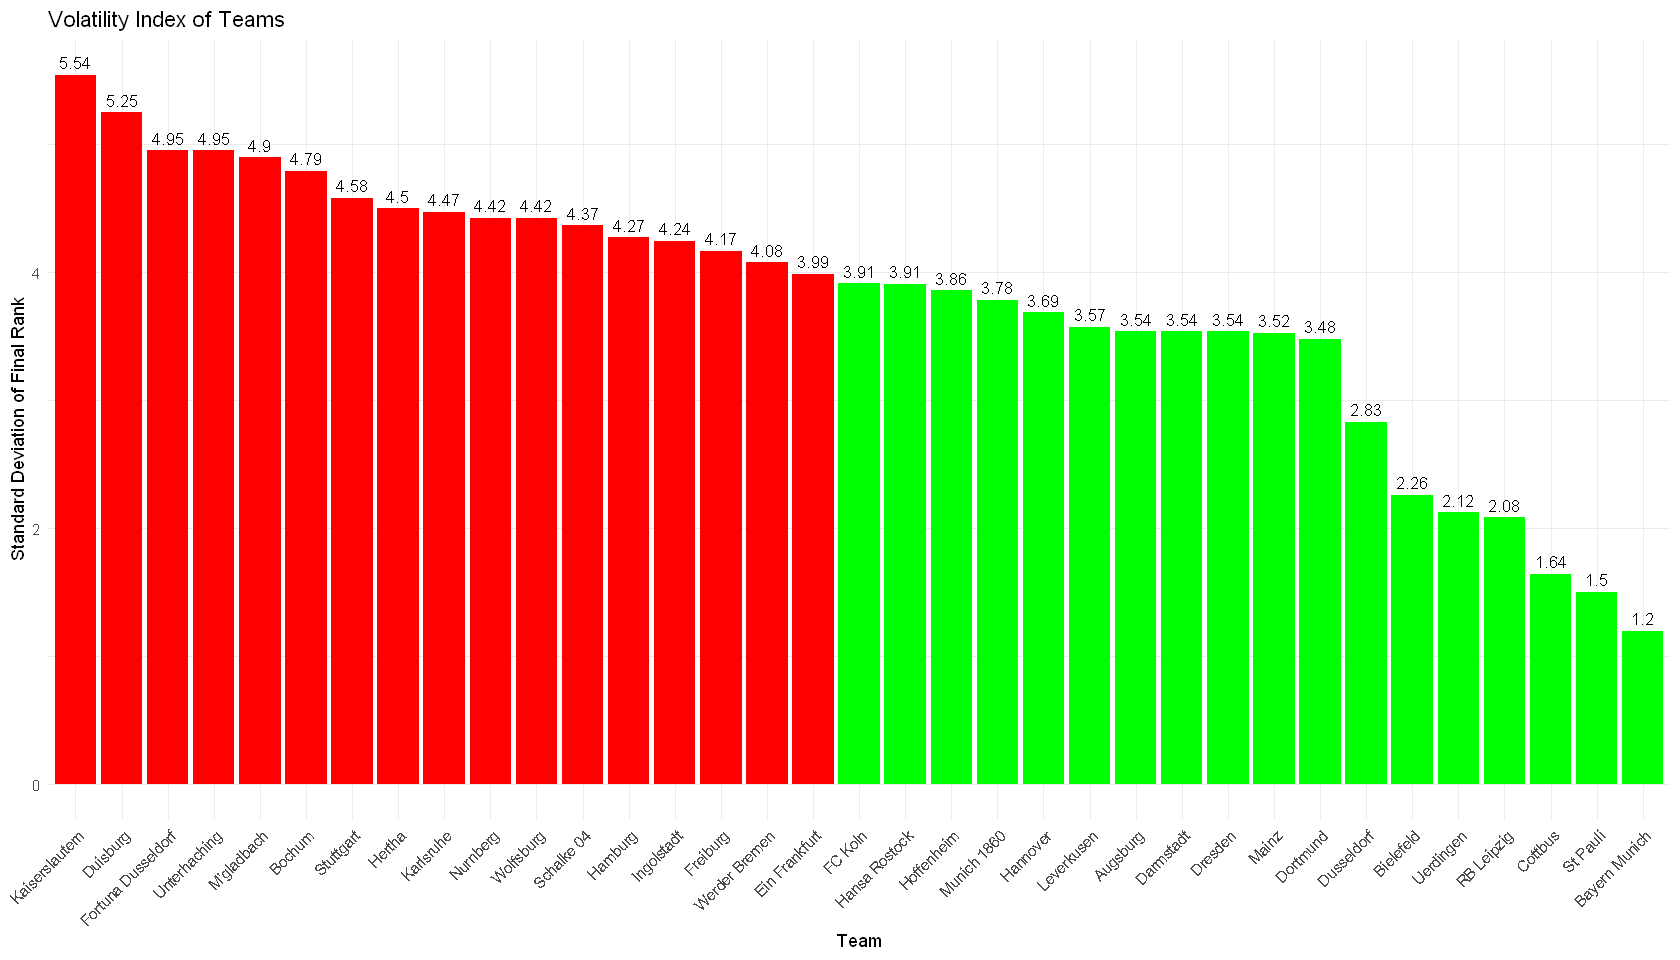

In [ ]:
team_volatility <- df2 %>%
  group_by(TEAM) %>%
  summarise(Volatility = sd(POSITION), .groups = "drop")

team_volatility <- na.omit(team_volatility)

team_volatility <- team_volatility %>%
  mutate(VolatilityCategory = ifelse(Volatility <= median(Volatility), "Consistent", "Unstable"))

ggplot(team_volatility, aes(x = reorder(TEAM, -Volatility), y = Volatility, fill = VolatilityCategory)) +
  geom_bar(stat = "identity", show.legend = FALSE) + 
  geom_text(aes(label = round(Volatility, 2)), vjust = -0.5, size = 3.5, color = "black") +
  scale_fill_manual(values = c("Consistent" = "green", "Unstable" = "red")) +
  labs(title = "Volatility Index of Teams",
       x = "Team",
       y = "Standard Deviation of Final Rank") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

## Part 4: Rivalries & Big Match Patterns

1. Head-to-Head Matrix for Selected Rivalries

- Select 5 key rivalries.
- Create a facet grid of win/draw/loss bar charts per rivalry.
- Annotate biggest win margins.

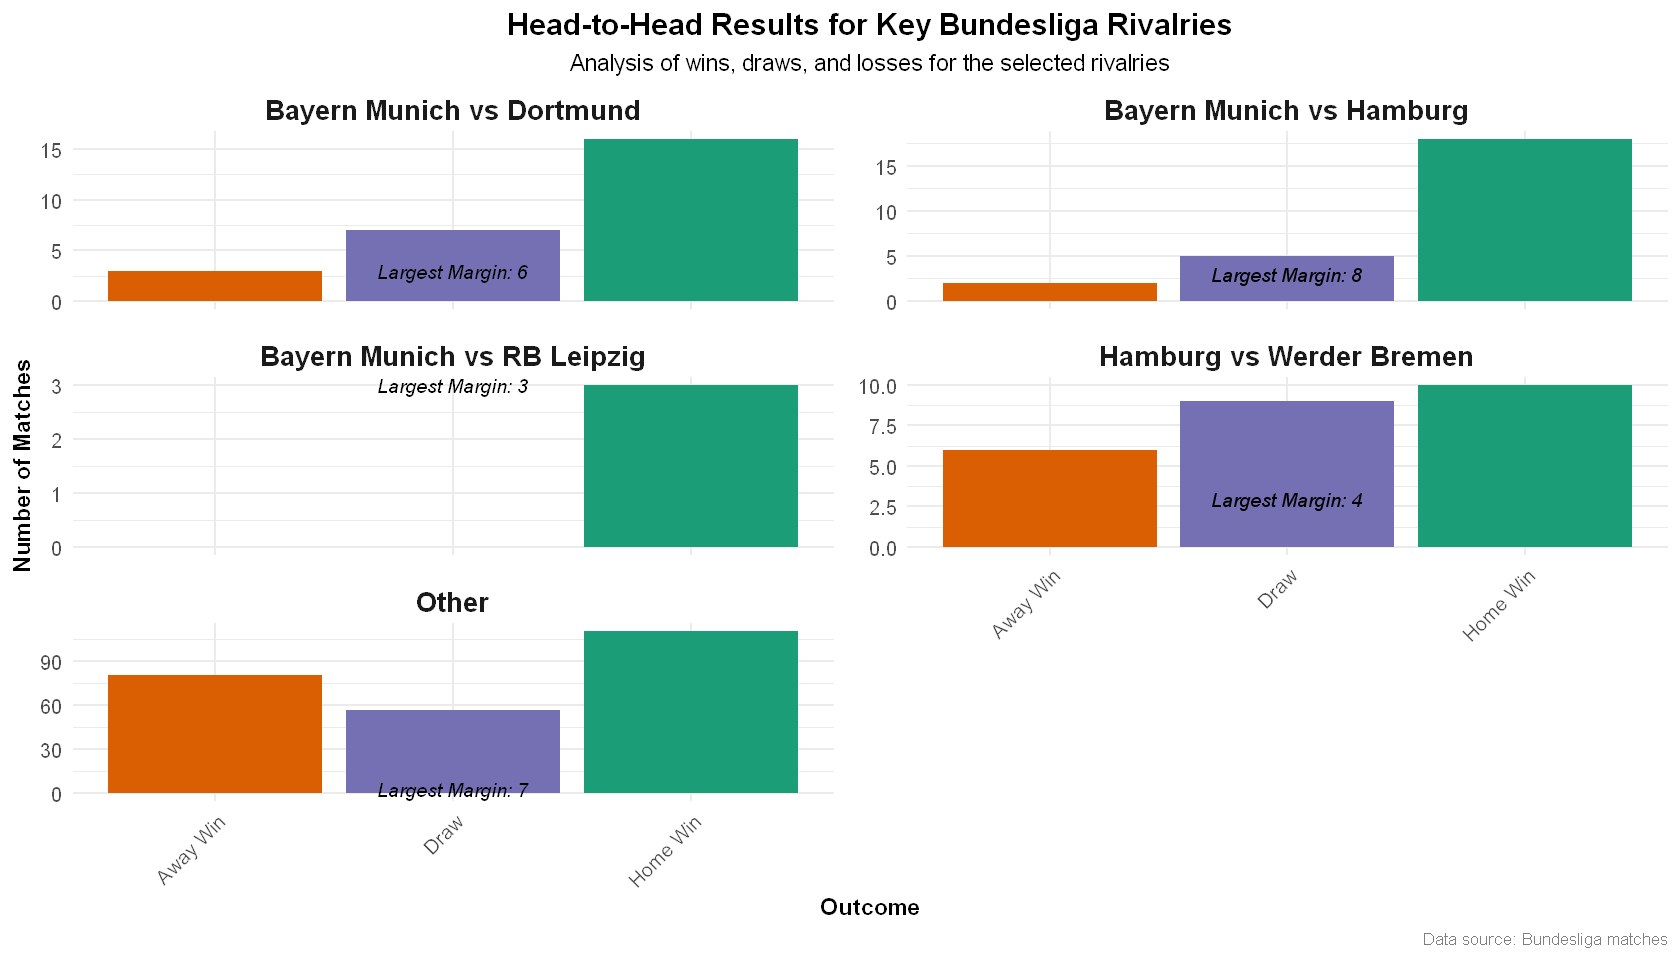

In [ ]:
rivalries <- c("Bayern Munich vs Dortmund", 
               "Bayern Munich vs Hamburg", 
               "Bayern Munich vs RB Leipzig", 
               "Hamburg vs Werder Bremen", 
               "Bayer Leverkusen vs Borussia Dortmund")

df_rivalries <- df %>%
  filter((HOMETEAM %in% c("Bayern Munich", "Dortmund", "Hamburg", "RB Leipzig", "Werder Bremen", "Bayer Leverkusen")) & 
         (AWAYTEAM %in% c("Bayern Munich", "Dortmund", "Hamburg", "RB Leipzig", "Werder Bremen", "Bayer Leverkusen"))) %>%
  mutate(Outcome = case_when(
    FTHG > FTAG ~ "Home Win",
    FTHG < FTAG ~ "Away Win",
    TRUE ~ "Draw"
  ),
  Rivalry = case_when(
    HOMETEAM == "Bayern Munich" & AWAYTEAM == "Dortmund" ~ "Bayern Munich vs Dortmund",
    HOMETEAM == "Bayern Munich" & AWAYTEAM == "Hamburg" ~ "Bayern Munich vs Hamburg",
    HOMETEAM == "Bayern Munich" & AWAYTEAM == "RB Leipzig" ~ "Bayern Munich vs RB Leipzig",
    HOMETEAM == "Hamburg" & AWAYTEAM == "Werder Bremen" ~ "Hamburg vs Werder Bremen",
    HOMETEAM == "Bayer Leverkusen" & AWAYTEAM == "Borussia Dortmund" ~ "Bayer Leverkusen vs Borussia Dortmund",
    HOMETEAM == "Bayer Leverkusen" & AWAYTEAM == "RB Leipzig" ~ "Bayer Leverkusen vs RB Leipzig",  # Fixed rivalry
    TRUE ~ "Other"
  ))

df_rivalries %>%
  mutate(Margin = abs(FTHG - FTAG)) %>%
  group_by(Rivalry) %>%
  filter(Margin == max(Margin)) %>%
  ungroup() -> largest_margins

ggplot(df_rivalries, aes(x = Outcome, fill = Outcome)) +
  geom_bar(stat = "count", show.legend = FALSE) +
  facet_wrap(~Rivalry, scales = "free_y", ncol = 2) +
  scale_fill_manual(values = c("Home Win" = "#1b9e77", "Away Win" = "#d95f02", "Draw" = "#7570b3")) +
  labs(title = "Head-to-Head Results for Key Bundesliga Rivalries",
       subtitle = "Analysis of wins, draws, and losses for the selected rivalries",
       x = "Outcome",
       y = "Number of Matches",
       caption = "Data source: Bundesliga matches") +
  theme_minimal(base_size = 14) +
  theme(strip.text = element_text(face = "bold", size = 16), 
        plot.title = element_text(face = "bold", size = 18, hjust = 0.5),
        plot.subtitle = element_text(size = 14, hjust = 0.5),
        axis.title = element_text(face = "bold", size = 14),
        axis.text = element_text(size = 12),
        plot.caption = element_text(size = 10, color = "grey50"),
        panel.spacing = unit(1, "lines")) +
  geom_text(data = largest_margins,
            aes(x = 2, y = 3,
                label = paste("Largest Margin:", Margin)),
            color = "black", size = 4, fontface = "italic") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


### 2. Upset Visualizer
 
- Define “upset” as a team >8 places below beating a top-5 team.
- Scatterplot of upsets: x-axis = rank difference, y-axis = goal difference.
- Encode team colors; highlight and label famous upsets

Note you can define top 5 by most points, most scorred goals, less consided goals.

## Part 5: Overall performance (R and Python)

Define unique color for each team per season. For each season create horizontal bar plot using total \
number of points. Highlighting the winner with the unique color that you assigned to it. Save all \
graphs in pdf.